## 2D attempt at solving the bidomain equations:

In [1]:
from fenics import *
import numpy as np
from configs import *
from mesh_generator import mesh_maker
import matplotlib.pyplot as plt

### Generating a mesh:

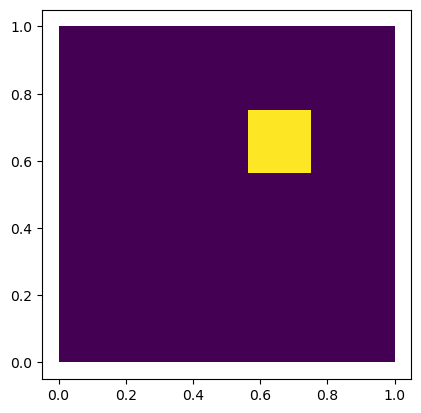

In [2]:
mesh, cellfunction, facetfunction = mesh_maker()
torsomesh = SubMesh(mesh, cellfunction, 0)
heartmesh = SubMesh(mesh, cellfunction, 1)
plot(cellfunction)

### Bidomain model:

In [3]:
# fibers, parametrized with mesh
# def fib(mesh):
#    coords = SpatialCoordinate(mesh)
#    norm = sqrt(dot(coords, coords))
#    vector_field = as_vector([coords[1] / norm, -coords[0] / norm])
#    return vector_field

V = VectorFunctionSpace(mesh, "Lagrange", 2, 2)

fib = Expression(
    ("x[1]/sqrt(pow(x[0],2) + pow(x[1],2))", "-x[0]/sqrt(pow(x[0],2) + pow(x[1],2))"),
    degree=2,
)
fibers = project(fib, V)

# conductivities
sigma_il = Constant(SIGMA_IL)
sigma_it = Constant(SIGMA_IT)
sigma_el = Constant(SIGMA_EL)
sigma_et = Constant(SIGMA_ET)
sigma_tlt = Constant(SIGMA_TLT)

d = mesh.topology().dim()

# sigma_i = Expression("sigma_it * Identity(d) + (sigma_il - sigma_it) * outer(fib(msh), fib(msh)",
#                     msh=mesh, d=d, sigma_it=sigma_it, sigma_il=sigma_il, fib=fib)
sigma_i = sigma_it * Identity(d) + (sigma_il - sigma_it) * outer(fib, fib)
# sigma_e = Expression("sigma_et * Identity(d) + (sigma_el - sigma_et) * outer(fib(msh), fib(msh)",
#                     msh=mesh, d=d, sigma_el=sigma_el, sigma_et=sigma_et, fib=fib)
sigma_e = sigma_et * Identity(d) + (sigma_el - sigma_et) * outer(fib, fib)
# sigma_t = Expression("sigma_tlt * Identity(d)",
#                     d=d, sigma_tlt=sigma_tlt)
sigma_t = sigma_tlt * Identity(d)

In [4]:
# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure("dx")(subdomain_data=cellfunction)
ds = Measure("ds")(subdomain_data=facetfunction)

In [5]:
# Define function space
P1 = FiniteElement("P", triangle, 2)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)

# Define test functions
phi, psi, theta = TestFunctions(V)

# Define functions
v = Function(V)
v_n = Function(V)

V_m, u, w = split(v)
V_m_n, u_n, w_n = split(v_n)

In [6]:
# Define expressions used in variational forms
dt = Constant(DT)
A_m = Constant(A_M)
B_m = Constant(B_M)
C_m = Constant(C_M)
I_app = Constant(1)  # bezveze, treba promijeniti da bude realno
# I_ion = interpolate(I_ion_expression(V_m=V_m, w=w), V)
# g = interpolate(g_expression(V_m=V_m, w=w), V)

In [7]:
# zasad ovako
I_ion = Constant(1)
g = Constant(1)

In [8]:
# Define variational problem
F1 = (
    A_m * (C_m * (V_m_n - V_m) + dt * I_ion) * phi * dx(1)
    + dt * inner(dot(sigma_i, grad(V_m+u)), grad(phi)) * dx(1)
    - dt * A_m * I_app * phi * dx(1)
)
F2 = (
    inner(dot(sigma_i + sigma_e, grad(u)), grad(psi)) * dx(1)
    + inner(dot(sigma_i, grad(V_m)), grad(psi)) * dx(1)
    + inner(dot(sigma_t, grad(u)), grad(psi)) * dx(0)
)
F3 = (w_n - w + dt * g) * theta * dx(1)
F = F1 + F2 + F3

In [9]:
# Create progress bar
progress = Progress("Time-stepping")
#set_log_level(False)

# Time-stepping
t = 0
for n in range(NUM_STEPS):
    # Update current time
    t += DT

    # Solve variational problem for time step
    solve(F == 0, v)

    # Update previous solution
    v_n.assign(v)

    # Update progress bar
    progress.update(t / T)

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Elapsed wall, usr, sys time: 1.9911e-05, 0, 0 (Build sparsity)
  Elapsed wall, usr, sys time: 1.3371e-05, 0, 0 (Apply (PETScVector))
  Elapsed wall, usr, sys time: 0.00121572, 0, 0 (Init tensor)
  Elapsed wall, usr, sys time: 8.61e-07, 0, 0 (Delete sparsity)
  Elapsed wall, usr, sys time: 1.496e-06, 0, 0 (Apply (PETScVector))
  Elapsed wall, usr, sys time: 1.6421e-05, 0, 0 (Apply (PETScVector))
  Elapsed wall, usr, sys time: 0.0085941, 0, 0 (Assemble system)
  Newton iteration 0: r (abs) = 1.668e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Matrix of size 49923 x 49923 has 1704969 (0.0684093%) nonzero entries.
  Elapsed wall, usr, sys time: 0.0533052, 0.09, 0.25 (Build sparsity)
  Elapsed wall, usr, sys time: 0.00201239, 0, 0.01 (Init tensor)
  Elapsed wall, usr, sys time: 8.89e-07, 0, 0 (Delete sparsity)
  Ela

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  078435b1b6a084172beba7fe044fdf81b1fceffb
*** -------------------------------------------------------------------------


  Extracted finite element for sub system: FiniteElement('Lagrange', triangle, 2)
  Extracted finite element for sub system: FiniteElement('Lagrange', triangle, 2)
  Extracted finite element for sub system: FiniteElement('Lagrange', triangle, 2)


/home/drvinko/miniconda3/lib/python3.11/site-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'colorbar'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)


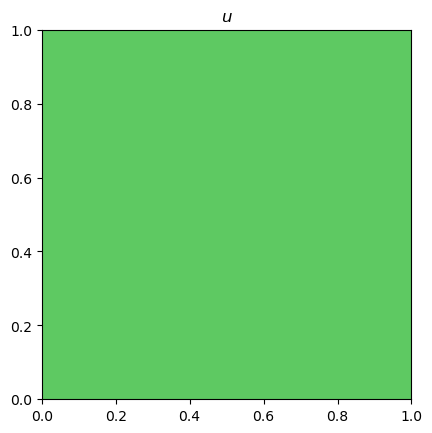

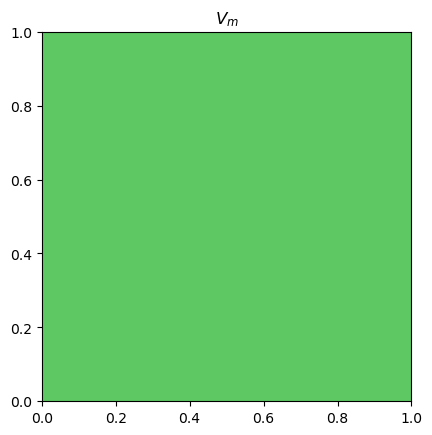

In [10]:
# Plot solution and gradient
V_m_n, u_n, w_n = v_n.split()
plot(u_n, title="$u$", colorbar=True)
plot(V_m_n, title="$V_m$")

In [11]:
u_n.vector().get_local()

array([0., 0., 0., ..., 0., 0., 0.])